# NYU Deep Learning Spring 2021 - 02: ConvNets, Natural signals and convolution 

## Input layer / samples (as natural signals)
$X = \{x^{i}\in\mathbb{R}^{n}|x^{i} \text{  is a data sample}\}^m _{i=1}$  (an n-dimensional data point)

$X = \{x^{i}:\Omega\mapsto\mathbb{R}^{c}, \omega\mapsto x^{i}(\omega)\}^m _{i=1}$ (from signal domain $\Omega$ to a given number of channels $c$)

### Signal domains examples:
- $\Omega = \{1,2,...,T/\Delta t\} \subset \mathbb{N},  c\in\{1,2,,5+1,...\}$  Discrete time signal with $\Delta t$ as sampling time and c channels (mono, stereo, dolby etc...)
- $\Omega = \{1,...,h\}\times\{1,...,w\} \subset \mathbb{N}^2, c\in\{1,3,30,...\}$ Images in Gray scales, RGB, Hyperspectral etc...

    mapped as $x(w_1,w_2)=\begin{bmatrix}r(w_1,w_2)\\g(w_1,w_2)\\b(w_1,w_2)\end{bmatrix}$
    
- $\Omega = \mathbb{R}^{4} \times \mathbb{R}^{4}, c = 1$ Hamiltonian in Space-Time domain

### Natural signal properties exploitet by Convnets
- **Stationarity**: A number of patterns keep repeating over and over
- **Locality**: Signal has strong correlation in local regions
- **Compositionality**: Global structure composed by local regions informations

## Enforcing locality in neural networks (Locality $\Rightarrow$ Sparsity)
<img src="material/CNN/sparsity.svg">

#### Connection Sparsity
- Reduces the amount of computation

## Enforcing Stationarity in neural networks (Stationarity $\Rightarrow$ Parameters Sharing)
<img src="material/CNN/param_sharing.svg">

#### Parameters sharing
 - **Faster convergence**: the same weight get gradients from multiple parts of the networks
 - **Generalization**: finds local patterns that can be repeated in different locations 
 - **Not constrained input size**: even after training, convnets can be applied to images with various input size to detect known patterns 
 - **Kernel indipendence**: allows parallelisation

## Kernels - 1D
<img src="material/CNN/kernel.svg">

- 7 dimensional input (input has 7 channels)
- 2 kernels (3 elements per each)
- 2 outputs (one coming from the first kernel, the other coming from the second, n_kernel = n_outputs)

## Padding - 1D
<img src="material/CNN/padding.svg">

#### Padding:
- allow to keep the same dimensionality along the network even if convolutions reduce dimensions along layers
- It's common practice to have odd domain size in kernels (3 in this example) to avoid assymetry during padding and to have univoque connections along neurons (otherwise it may cause blur)
- allow to mantain consistent internal network sizes

## Standard Spatial CNN

**Multiple Layers**:
- Convolutions (data rotations)
- Non-linearities such as ReLu and Leaky-ReLu (data squashing)
- Pooling: used to reduce spatial dimensionality
- Batch normalization: allows to train very long network without having issues in convergences

**Residual bypass connection**:
- enhance training performance of very deep networks

<img src="material/CNN/standard_cnn.svg">

**Intuition**: the network will take a very "flat" input (RGB h x w image in this case) containing some kind of spatial information spread along the domain (in this case along colorspace domain), we may see the "thickness" of the input as a specific **characteristic information** at a given location (in this case RGB values).

At the end of the network we gonna have a very long vector (if we consider a classification problem) in which each of its element correspond to a characteristic information that was previously "hidden" in the considered domain.

The network reduce the domain information (spatial information) and increase the characteristic information

## Pooling - 2D

Operation used to "summarize" or "condensate" the content of a given part of the considered domain

- **LP Pooling**:

    $||\vec{x}||_p:=\bigl(\Sigma_i|x_i|\bigr)^{1/p}$
- **Max Pooling**:

    $||\vec{x}||_{\inf}:=\text{max}(\vec{x})$
    
The pooling is applied with a certain stride accross the domain, this will allow reduce the computations. Can be done also with strided convolution.

<img src="material/CNN/pooling.svg">

**Intuition**: Pooling reduce the domain size while keeping the same number of channels

# Experiment outline:

- Train a ConvNet using pytorch
- Illustrate how ConvNets make use of specific assumptions

## To perform well, we need to incorporate some prior knowledge about the problem 
- Assumptions helps us when they are true
- They hurts us when they are false
- We want to make just the right amoutn of assumptions, no more than that

## In Deep Learning:
- Many layers -> Compositionality
- Convolutions -> Locality + Stationarity of images
- Pooling -> Invariance of object class to translation 

In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [4]:
# function to count the number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)
We can use some PyTorch dataloader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

0.3%

97.9%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



60.0%

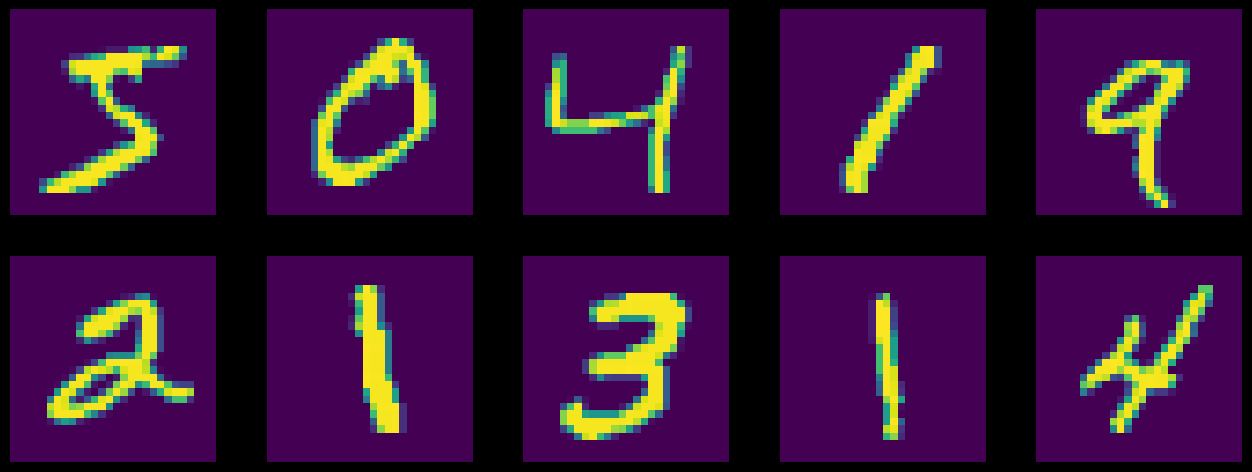

In [7]:
# show some sample images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create model classes

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Running on a GPU: device string
Switching between CPU and GPU in PyTorch is controlled via a device string, which will seamlessy determine whether GPU is available, falling back to CPU if not.

In [9]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [10]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.281976
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.781367
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.288511
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.783958
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.758289
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.535188
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.607644
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.301220
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.362693
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.440666

Test set: Average loss: 0.4036, Accuracy: 8835/10000 (88%)



# Train a ConvNet with the same number of parameters

In [12]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314762
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.924771
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.519753
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.547285
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.497724
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.144018
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.196605
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.095131
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.111760
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.097284

Test set: Average loss: 0.1431, Accuracy: 9533/10000 (95%)



# The ConvNets performs better with the same number of parameters, thanks to its uso of prior knowledge about images
- Use of **Convolution** exploits Locality and Stationarity in images
- Use of **Pooling** builds some translation invariance

# What happen if the assumptions are no longer true?

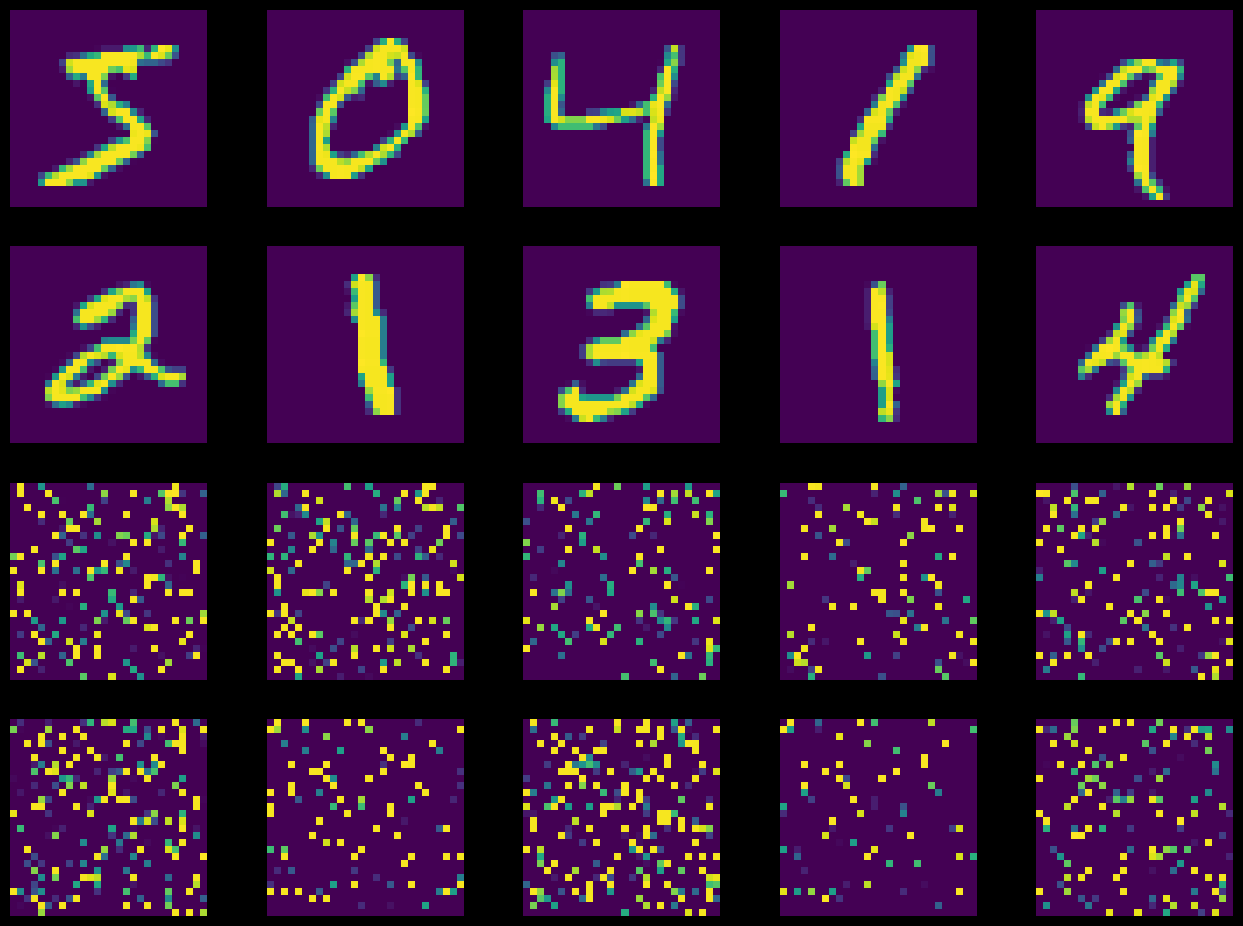

In [13]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# Train ConvNet with scrambled pixels

In [14]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311962
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.278999
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.152199
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.818345
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.361082
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.886008
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.714755
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.523441
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.551760
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.551804

Test set: Average loss: 0.6045, Accuracy: 8063/10000 (81%)



# Train fully-connected networks with scrambled pixels

In [15]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310260
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.771684
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.779016
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.704674
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.476563
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.312859
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.388340
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.456639
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.549411
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.274271

Test set: Average loss: 0.3969, Accuracy: 8833/10000 (88%)



# Conclusion: The ConvNet's performance drops when we permute the pixels while the fully-connected Network's performance stays the same
- **ConvNet** makes the assumption that pixels lie on a grid and are stationary/local
- It loses performance when previous assumption is not True
- **Fully-connected Network** does not make the previous assumption
- It does less well when previous assumption is true, since it doesn't exploit this prior knowledge
- When stationary/local assumption is not true, fully-connected Networks does not suffer for this fact

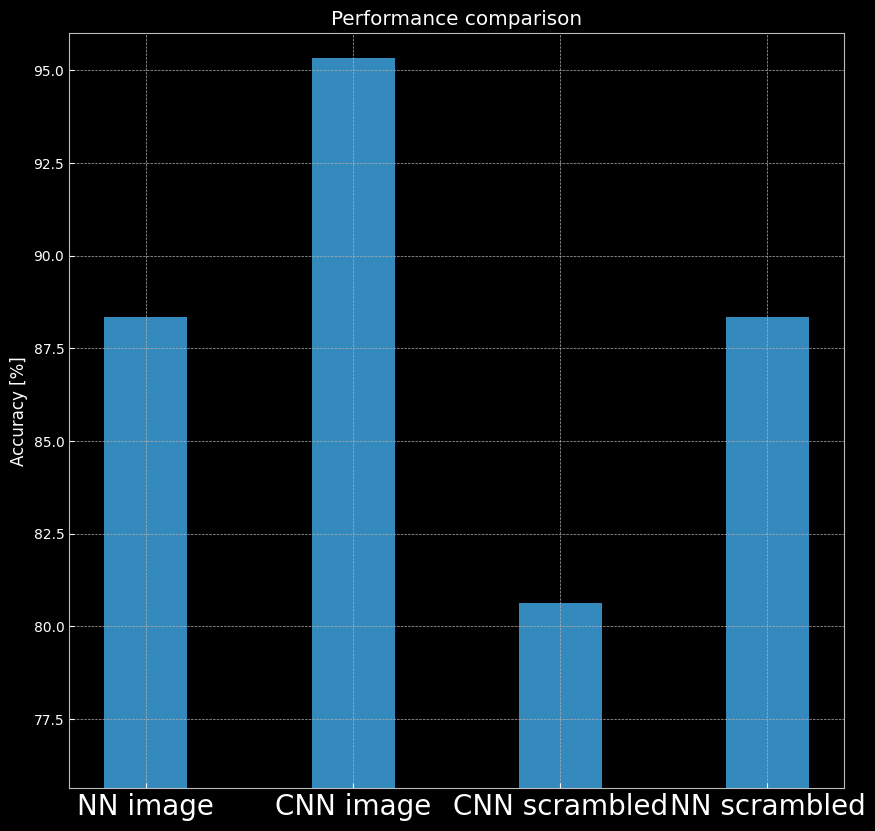

In [16]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');